<h1><left><font size="6"> Prediction with lightgbm model</font></center></h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg"></img>


- <a href='#1'>1.Introduction</a>
    - <a href='#1.1'>1.1.overview</a>
- <a href='#2'>2.Libraries and Data</a>
    - <a href='#2.1'>2.1.Libraries</a>
    - <a href='#2.2'>2.2.loading Data</a>
    - <a href='#2.3'>2.3.Data overview</a>
- <a href='#3'>3.Exploratory Data Analysis</a>
    - <a href='#3.1'>3.1.class imbalance</a>
    - <a href='#3.2'>3.2.TSNE plot</a>
    - <a href='#3.3'>3.3.PCA</a>
- <a href='#4'>4.Feature Engineering</a>
    - <a href='#4.1'>4.1.New columns and augment</a>
- <a href='#5'>5.Lightgbm Model Parameters and training</a>
    - <a href='#5.1'>5.1.Parameters</a>
    - <a href='#5.2'>5.2.Training</a>
    - <a href='#5.3'>5.3.submission</a>
    - <a href='#5.4'>5.4.Feature importance</a>
- <a href='#6'>6.End notes</a>   
    

# <a id='1'>1.Introduction</a>

### <a id='1.1'>1.1.overview</a>

In this challenge, Kagglers are invited to help identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

# <a id='2'>2.Libraries and Data</a>

### <a id='2.1'>2.1.Libraries</a>

plotly and matplotlib are used for EDA. Lightgbm is used for training and prediction.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import seaborn as sns#visualization
import itertools
import warnings
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

### <a id='2.2'>2.2.Loading Data</a>

In [2]:

random_state = 42
np.random.seed(random_state)
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
data = pd.read_csv('../input/train.csv')
data.shape

(200000, 202)

### <a id='2.3'>2.3.Data Overview</a>

In [3]:
data.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

# <a id='3'>3.Exploratory Data Analysis</a>

### <a id='3.1'>3.1.class imbalance</a>

In [4]:
#labels
lab = data["target"].value_counts().keys().tolist()
#values
val = data["target"].value_counts().values.tolist()

trace = go.Pie(labels = lab ,
               values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "class imbalance",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )

data1 = [trace]
fig = go.Figure(data = data1,layout = layout)
py.iplot(fig)

### <a id='3.2'>3.2.TSNE plot</a>

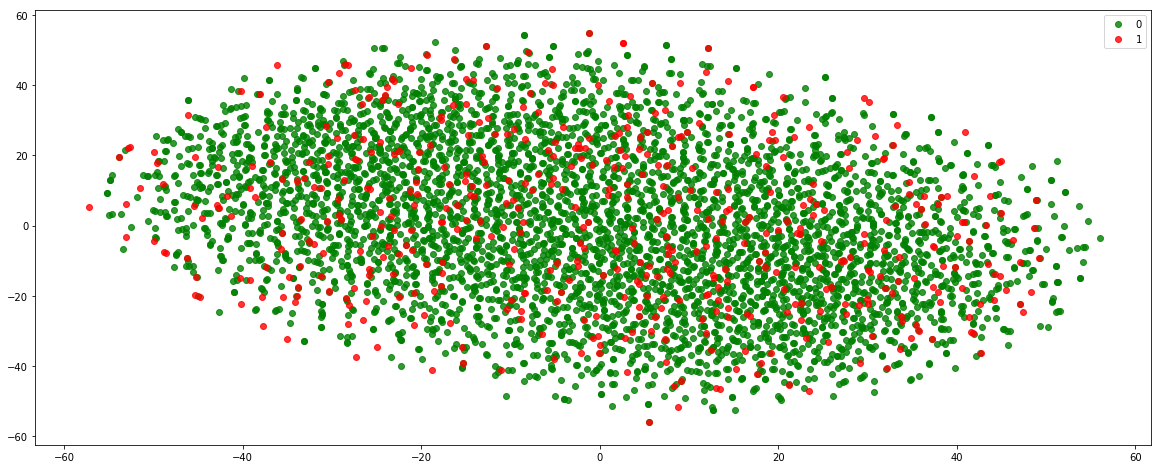

In [5]:
features = [c for c in data.columns if c not in ['ID_code', 'target']]
X = data[features].head(n=5000)
Y = data['target'].head(n=5000)

def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(20, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='0')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='1')

    plt.legend(loc='best');
    plt.show();
    
tsne_plot(X, Y, "tsne.png")

### <a id='3.3'>3.3.PCA</a>

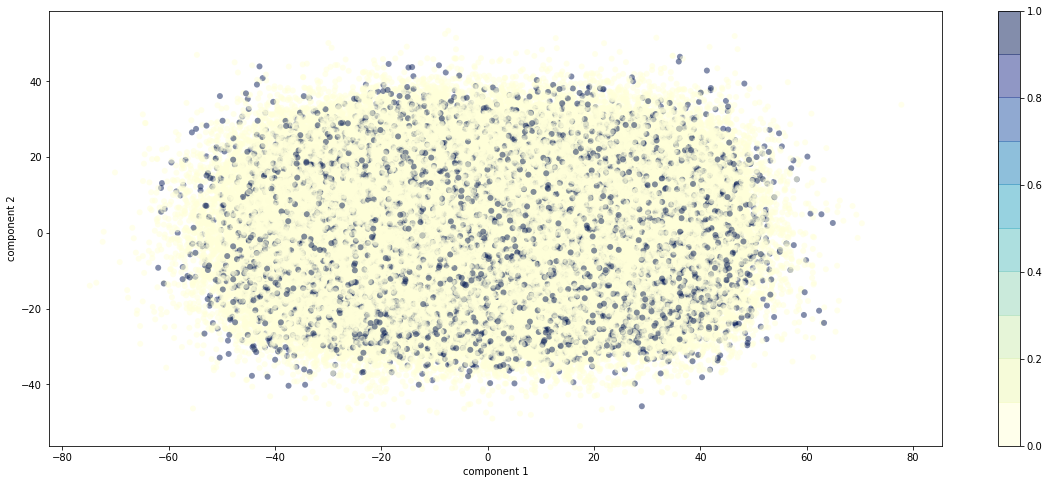

In [6]:
X = data.iloc[:,1:202]

pca = PCA(2)  
projected = pca.fit_transform(X)

plt.figure(figsize=(20, 8))
plt.scatter(projected[:, 0], projected[:, 1],
            c=X['target'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('YlGnBu', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

# <a id='4'>4.Feature Engineering</a>

### <a id='4.1'>4.1.New columns and augment</a>

In [7]:

def process_data(df_train, df_test):
    idx = [c for c in df_train.columns if c not in ['ID_code', 'target']]
    for df in [df_test, df_train]:
        for feat in idx:
            df['r2_'+feat] = np.round(df[feat], 2)
            df['r2_'+feat] = np.round(df[feat], 2)
        #df['sum'] = df[idx].sum(axis=1)
        #df['min'] = df[idx].min(axis=1)
        #df['max'] = df[idx].max(axis=1)
        #df['mean'] = df[idx].mean(axis=1)
        df['std'] = df[idx].std(axis=1)
        df['skew'] = df[idx].skew(axis=1)
        df['kurt'] = df[idx].kurtosis(axis=1)
        df['med'] = df[idx].median(axis=1)
    print('Train and test shape:',df_train.shape, df_test.shape)
    return df_train, df_test


#process_data(df_train,df_test)


def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y



# <a id='5'>5.Lightgbm Model Parameters and training</a>

### <a id='5.1'>5.1.Parameters</a>

In [8]:

lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.335,
    "feature_fraction" : 0.041,
    "min_data_in_leaf": 80,
    "min_sum_hessian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "num_threads": 4,
    "scale_pos_weight":0.8882836,
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : -1,
    "seed": random_state
}

### <a id='5.2'>5.2.Training</a>

In [9]:

target = df_train['target']
num_folds = 8
features = [c for c in df_train.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(df_train))
getVal = np.zeros(len(df_train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    X_train, y_train = df_train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = df_train.iloc[val_idx][features], target.iloc[val_idx]

    #N = 2
    #for i in range(N):
        #print("fold split:{}".format(fold_ + 1))
        #print("fold N:{}".format(i))

    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)

    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    clf = lgb.train(lgb_params, trn_data, 1000000, valid_sets=[trn_data, val_data], verbose_eval=4000,
                    early_stopping_rounds=4000)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx] += clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[4000]	training's auc: 0.912113	valid_1's auc: 0.893545
[8000]	training's auc: 0.9222	valid_1's auc: 0.89845
[12000]	training's auc: 0.929708	valid_1's auc: 0.899331
[16000]	training's auc: 0.936438	valid_1's auc: 0.899209
Early stopping, best iteration is:
[13603]	training's auc: 0.932444	valid_1's auc: 0.899376
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[4000]	training's auc: 0.912403	valid_1's auc: 0.892474
[8000]	training's auc: 0.922447	valid_1's auc: 0.896066
[12000]	training's auc: 0.929948	valid_1's auc: 0.896405
Early stopping, best iteration is:
[11039]	training's auc: 0.928241	valid_1's auc: 0.896565
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[4000]	training's auc: 0.910709	valid_1's auc: 0.89759
[8000]	training's auc: 0.920853	valid_1's auc: 0.900657
[12000]	training's auc: 0.928431	valid_1's auc: 0.900895
Early stopping,

### <a id='5.3'>5.3.Submission</a>

In [10]:

num_sub = 10
print('Saving the Submission File')
sub = pd.DataFrame({"ID_code": df_test.ID_code.values})
sub["target"] = predictions
sub.to_csv('submission{}.csv'.format(num_sub), index=False)


Saving the Submission File


### <a id='5.4'>5.4.Feature importance</a>

In [11]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
data=best_features.sort_values(by="importance",ascending=False)

data = [go.Bar(
            x=data['importance'],
            y=data['feature'],
            orientation = 'h'
)]

layout = go.Layout(
    title='Feature importance',
    font=dict(family='Courier New, monospace', size=12, color='#9467bd'),
    autosize=False,
    width=1200,
    height=2500,
    plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='automargin')


# <a id='6'>6.End notes</a>

### References
### https://www.kaggle.com/gpreda/santander-eda-and-prediction
### https://www.kaggle.com/roydatascience/eda-pca-simple-lgbm-on-kfold-technique 
